In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore




In [3]:
data = pd.read_csv('/content/drive/MyDrive/files/benin-malanville.csv')
data2 = pd.read_csv('/content/drive/MyDrive/files/sierraleone-bumbuna.csv')
data3 = pd.read_csv('/content/drive/MyDrive/files/togo-dapaong_qc.csv')

In [4]:
columns = ['RH', 'WS', 'GHI', 'DNI', 'DHI']  # Replace with your column names
statistics = {}
for col in columns:
    if col in data.columns:
        statistics[col] = {
            'Mean': data[col].mean(),
            'Median': data[col].median(),
            'Variance': data[col].var(),
            'Skewness': data[col].skew(),
            'Kurtosis': data[col].kurt()
        }

stats_df = pd.DataFrame(statistics).transpose()
print("Summary Statistics:\n", stats_df)

Summary Statistics:
            Mean  Median       Variance  Skewness  Kurtosis
RH    54.487969    55.1     788.097191 -0.026653 -1.298555
WS     2.121113     1.9       2.571103  0.868406  1.579008
GHI  240.559452     1.8  109647.955903  1.028446 -0.460184
DNI  167.187516    -0.1   68492.386135  1.290260  0.172956
DHI  115.358961     1.6   25182.856923  1.210406  0.498993


In [5]:
def summarize_missing_values(dataset, file_name):
    missing_values = dataset.isnull().sum()
    missing_data = pd.DataFrame({
        'File': file_name,
        'Column': missing_values.index,
        'Missing Values Count': missing_values.values
    })
    # Filter out columns with no missing values
    missing_data = missing_data[missing_data['Missing Values Count'] > 0]
    return missing_data

# Summarize missing values for each dataset
missing_benin = summarize_missing_values(data, "benin-malanville.csv")
missing_sierraleone = summarize_missing_values(data2, "sierraleone-bumbuna.csv")
missing_togo = summarize_missing_values(data3, "togo-dapaong_qc.csv")

# Combine all summaries into a single DataFrame
combined_missing_data = pd.concat([missing_benin, missing_sierraleone, missing_togo], ignore_index=True)

# Display the combined missing values summary
print("\nColumns with Missing Values (File & Count):\n")
print(combined_missing_data[['File', 'Column', 'Missing Values Count']].to_string(index=False))



Columns with Missing Values (File & Count):

                   File   Column  Missing Values Count
   benin-malanville.csv Comments                525600
sierraleone-bumbuna.csv Comments                525600
    togo-dapaong_qc.csv Comments                525600


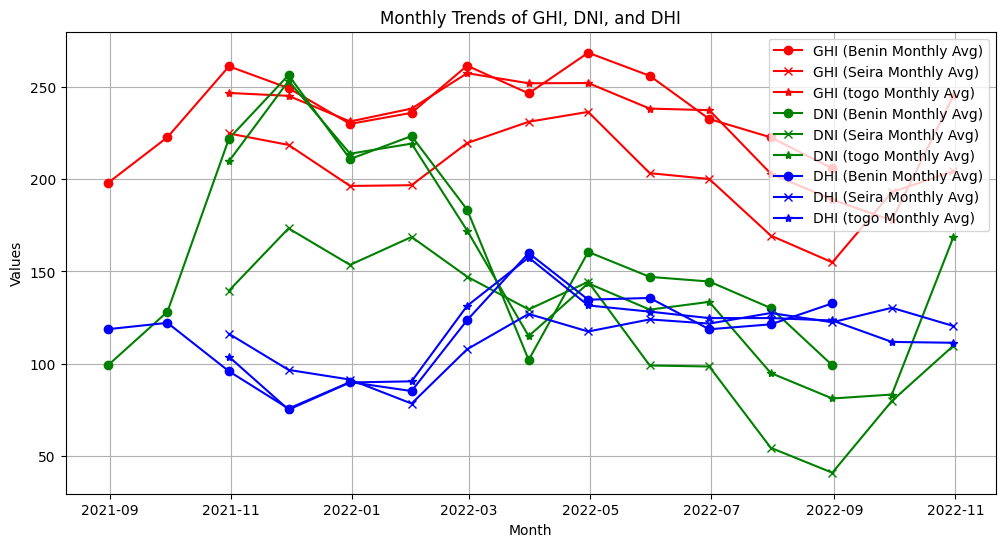

In [6]:

# Convert 'Timestamp' column to datetime format then Set the 'Timestamp' column as the index for easier resampling
data['Timestamp'] = pd.to_datetime(data['Timestamp'], errors='coerce')
data.set_index('Timestamp', inplace=True)
data2['Timestamp'] = pd.to_datetime(data2['Timestamp'], errors='coerce')
data2.set_index('Timestamp', inplace=True)
data3['Timestamp'] = pd.to_datetime(data3['Timestamp'], errors='coerce')
data3.set_index('Timestamp', inplace=True)

# Plot Monthly Data
monthly_data = data.resample('ME').mean()  # Resample by month and calculate the mean for numeric columns
monthly_data2 = data2.resample('ME').mean()
monthly_data3 = data3.resample('ME').mean()

plt.figure(figsize=(12, 6))

plt.plot(monthly_data.index, monthly_data['GHI'], label='GHI (Benin Monthly Avg)', marker='o', color="red")
plt.plot(monthly_data2.index, monthly_data2['GHI'], label='GHI (Seira Monthly Avg)', marker='x', color="red")
plt.plot(monthly_data3.index, monthly_data3['GHI'], label='GHI (togo Monthly Avg)', marker='*', color="red")

plt.plot(monthly_data.index, monthly_data['DNI'], label='DNI (Benin Monthly Avg)', marker='o', color="green")
plt.plot(monthly_data2.index, monthly_data2['DNI'], label='DNI (Seira Monthly Avg)', marker='x', color="green")
plt.plot(monthly_data3.index, monthly_data3['DNI'], label='DNI (togo Monthly Avg)', marker='*', color="green")

plt.plot(monthly_data.index, monthly_data['DHI'], label='DHI (Benin Monthly Avg)', marker='o', color="blue")
plt.plot(monthly_data2.index, monthly_data2['DHI'], label='DHI (Seira Monthly Avg)', marker='x', color="blue")
plt.plot(monthly_data3.index, monthly_data3['DHI'], label='DHI (togo Monthly Avg)', marker='*', color="blue")

plt.title('Monthly Trends of GHI, DNI, and DHI')
plt.xlabel('Month')
plt.ylabel('Values')
plt.legend()
plt.grid()
plt.show()

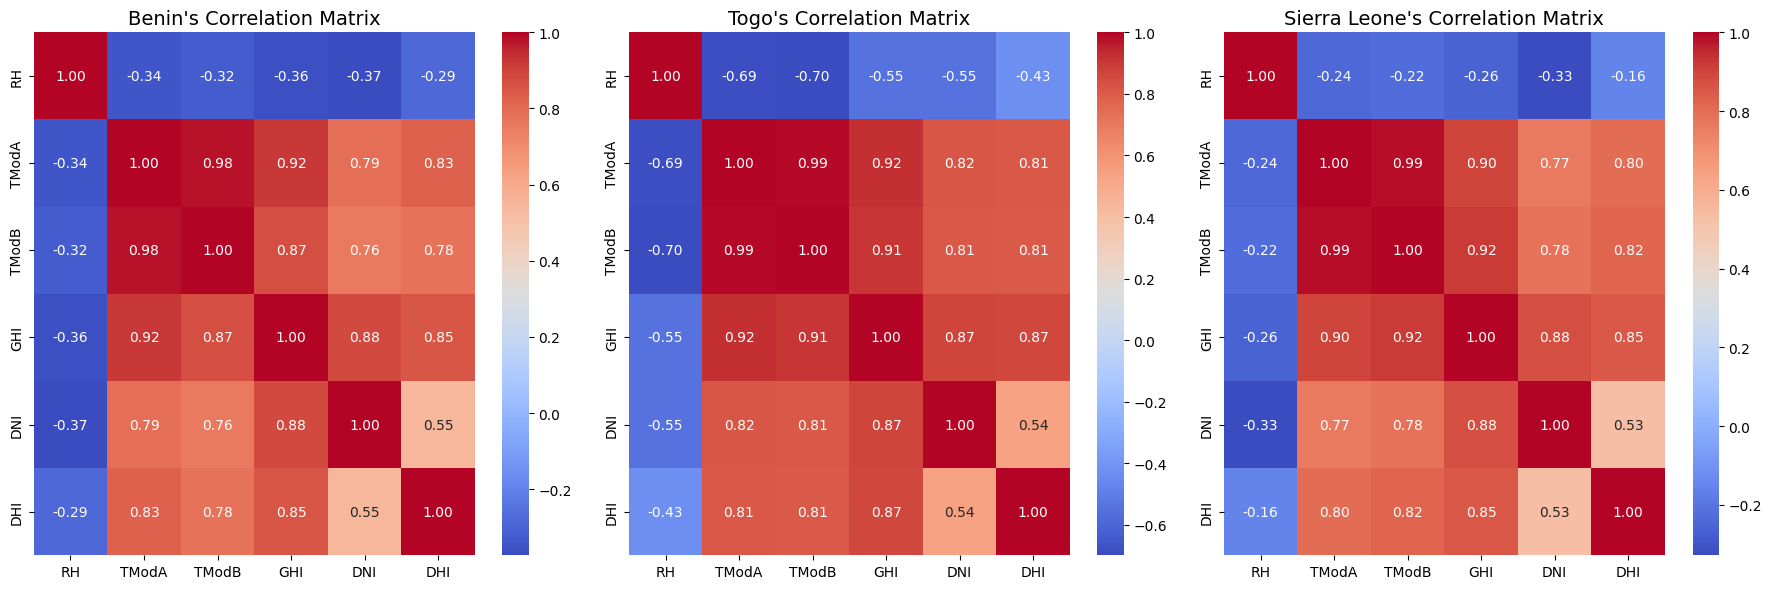

In [7]:
# @title Default title text
def correlation_plot(df, ax, name):
    # Compute correlation matrix for selected columns
    correlation_matrix = df[["RH", "TModA", 'TModB', 'GHI', 'DNI', 'DHI']].corr()

    # Plot the heatmap on the given axis (ax)
    sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", ax=ax)
    ax.set_title(f"{name}'s Correlation Matrix", fontsize=14)

# Create a figure with 1 row and 3 columns for the subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Call the function for each dataset and pass the axis to plot on
correlation_plot(data, axes[0], "Benin")
correlation_plot(data2, axes[1], "Togo")
correlation_plot(data3, axes[2], "Sierra Leone")

# Adjust layout to avoid overlap of titles/labels
plt.tight_layout()
plt.show()


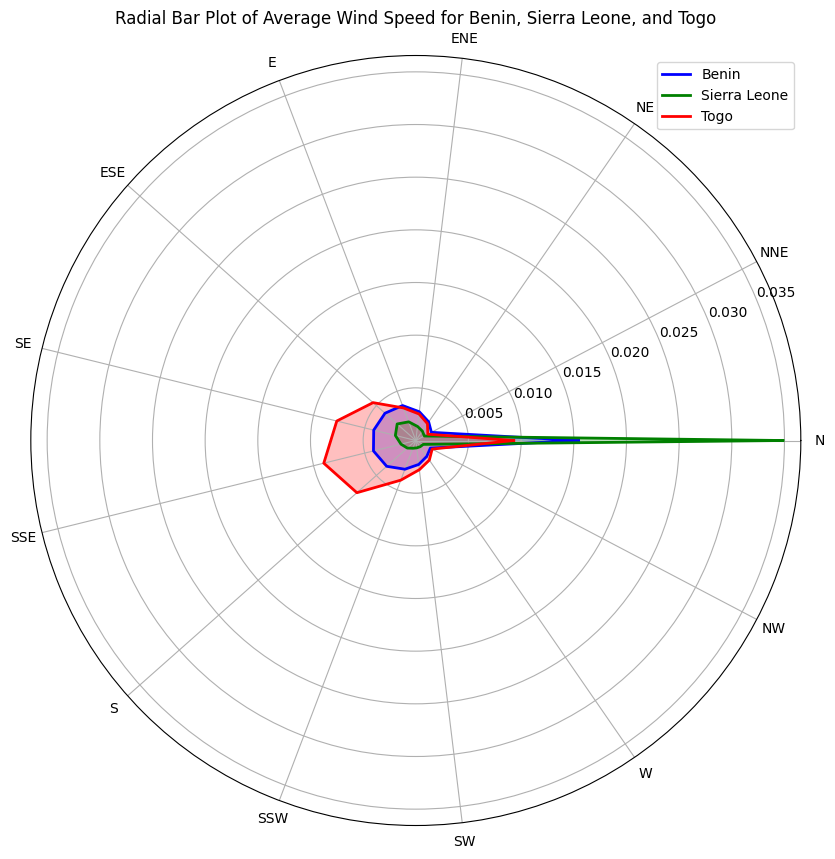

In [14]:
# Function to create radial bar plot for wind speed vs direction
def create_radial_plot(data, label, color):
    wind_bins = np.arange(0, 136, 10)
    wind_speed_bins = np.arange(0, data['WS'].max() + 1, 1)

    hist, xedges, yedges = np.histogram2d(data['WD'], data['WS'], bins=[wind_bins, wind_speed_bins])
    hist = hist / hist.sum()

    # Calculate average wind speed per direction bin
    average_speed = hist.mean(axis=1)

    # Create a radial bar plot
    angles = np.linspace(0, 2 * np.pi, len(average_speed), endpoint=False).tolist()
    average_speed = np.concatenate((average_speed, [average_speed[0]]))  # Close the loop
    angles += angles[:1]

    # Plotting
    ax.plot(angles, average_speed, label=label, color=color, linewidth=2)
    ax.fill(angles, average_speed, color=color, alpha=0.25)

# Create figure for radial plots
plt.figure(figsize=(10, 10))

# Create polar subplot
ax = plt.subplot(111, polar=True)

# Call the function for each dataset
create_radial_plot(data, "Benin", 'blue')
create_radial_plot(data2, "Sierra Leone", 'green')
create_radial_plot(data3, "Togo", 'red')

# Set direction labels
ax.set_xticks(np.linspace(0, 2 * np.pi, len(average_speed)-1, endpoint=False))  # Set direction labels
ax.set_xticklabels(['N', 'NNE', 'NE', 'ENE', 'E', 'ESE', 'SE', 'SSE', 'S', 'SSW', 'SW', 'W', 'NW'])

# Set the title and legend
ax.set_title('Radial Bar Plot of Average Wind Speed for Benin, Sierra Leone, and Togo')
ax.legend()

# Display the plot
plt.show()


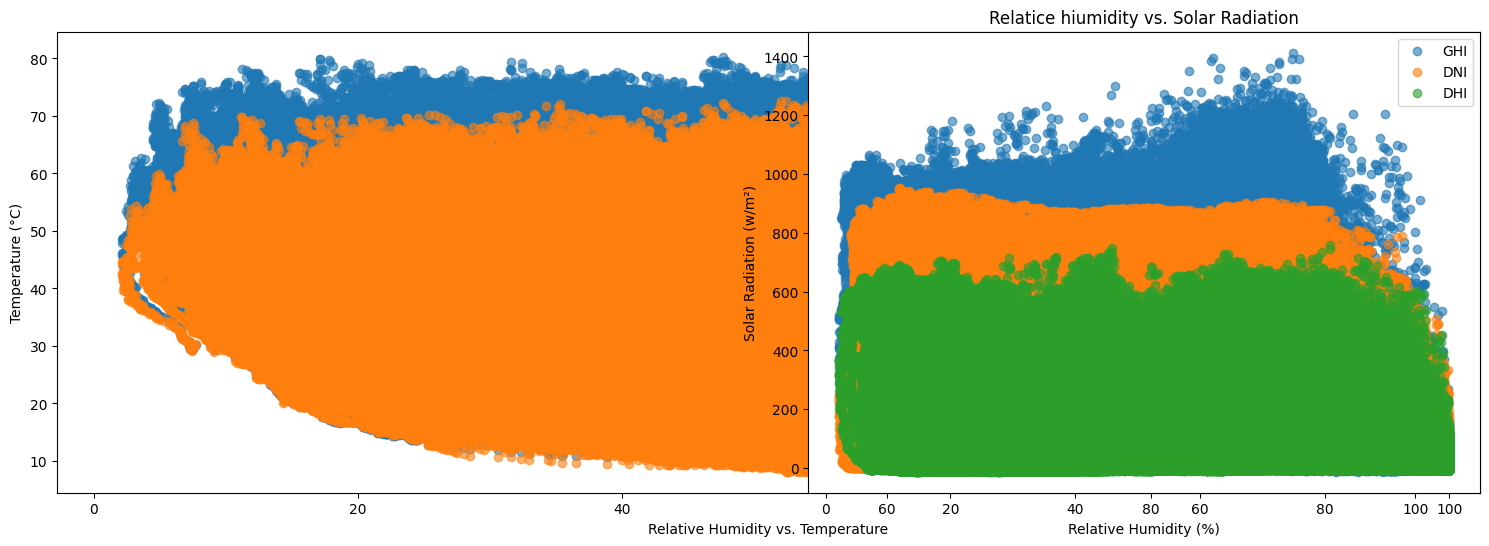

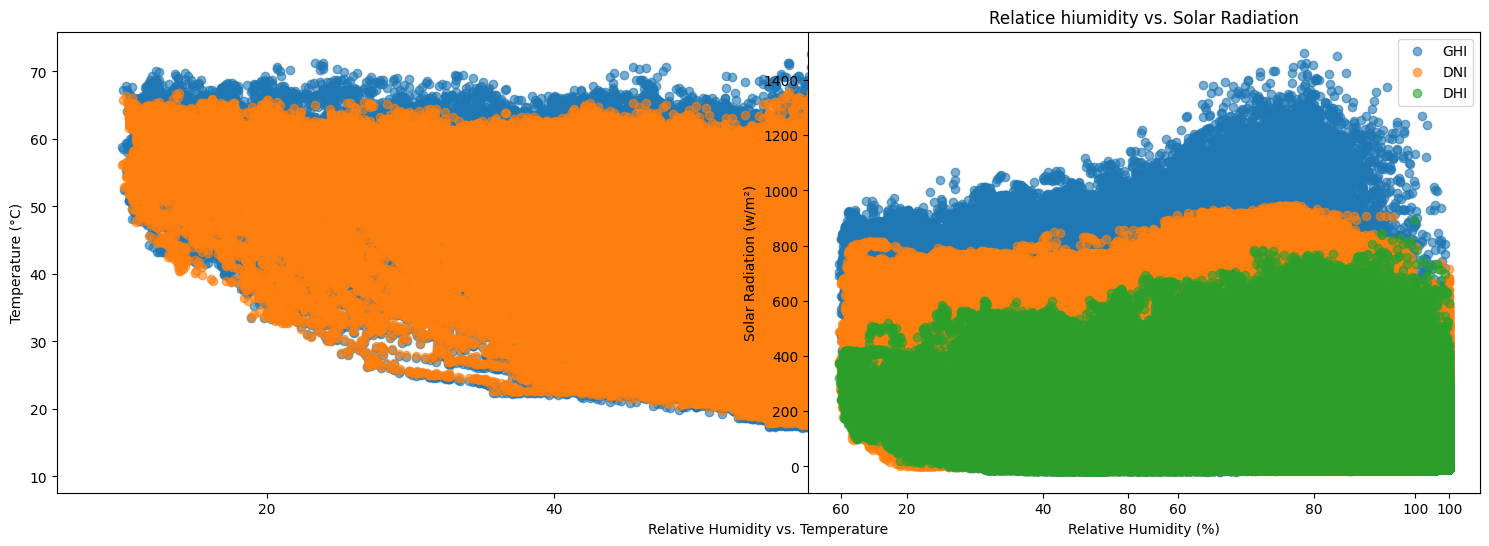

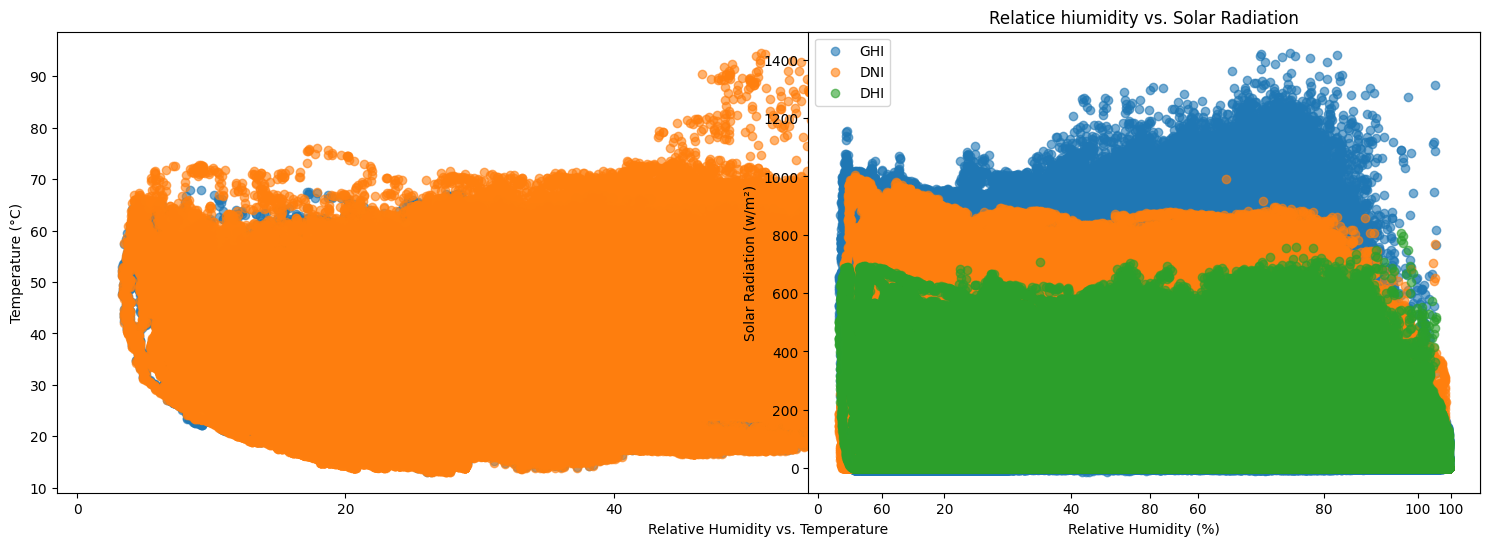

In [10]:
def temperature_analysis(df):
  plt.figure(figsize=(15,6))
  plt.scatter(data=df, x="RH", y='TModA', label='TModA', alpha=0.6)
  plt.scatter(data=df, x="RH", y='TModB', label='TModB', alpha=0.6)
  plt.xlabel('Relative Humidity vs. Temperature')
  plt.ylabel('Relative Humidity (%)')
  plt.ylabel("Temperature (°C)")
  plt.legend()

  plt.subplot(1,2,2)
  plt.scatter(data=df, x="RH", y='GHI', label='GHI', alpha=0.6)
  plt.scatter(data=df, x="RH", y='DNI', label='DNI', alpha=0.6)
  plt.scatter(data=df, x="RH", y='DHI', label='DHI', alpha=0.6)
  plt.title("Relatice hiumidity vs. Solar Radiation")
  plt.xlabel('Relative Humidity (%)')
  plt.ylabel('Solar Radiation (w/m²)')
  plt.legend()

  plt.tight_layout()
  return plt.show()

temperature_analysis(data)
temperature_analysis(data2)
temperature_analysis(data3)


KeyError: 'datetime'

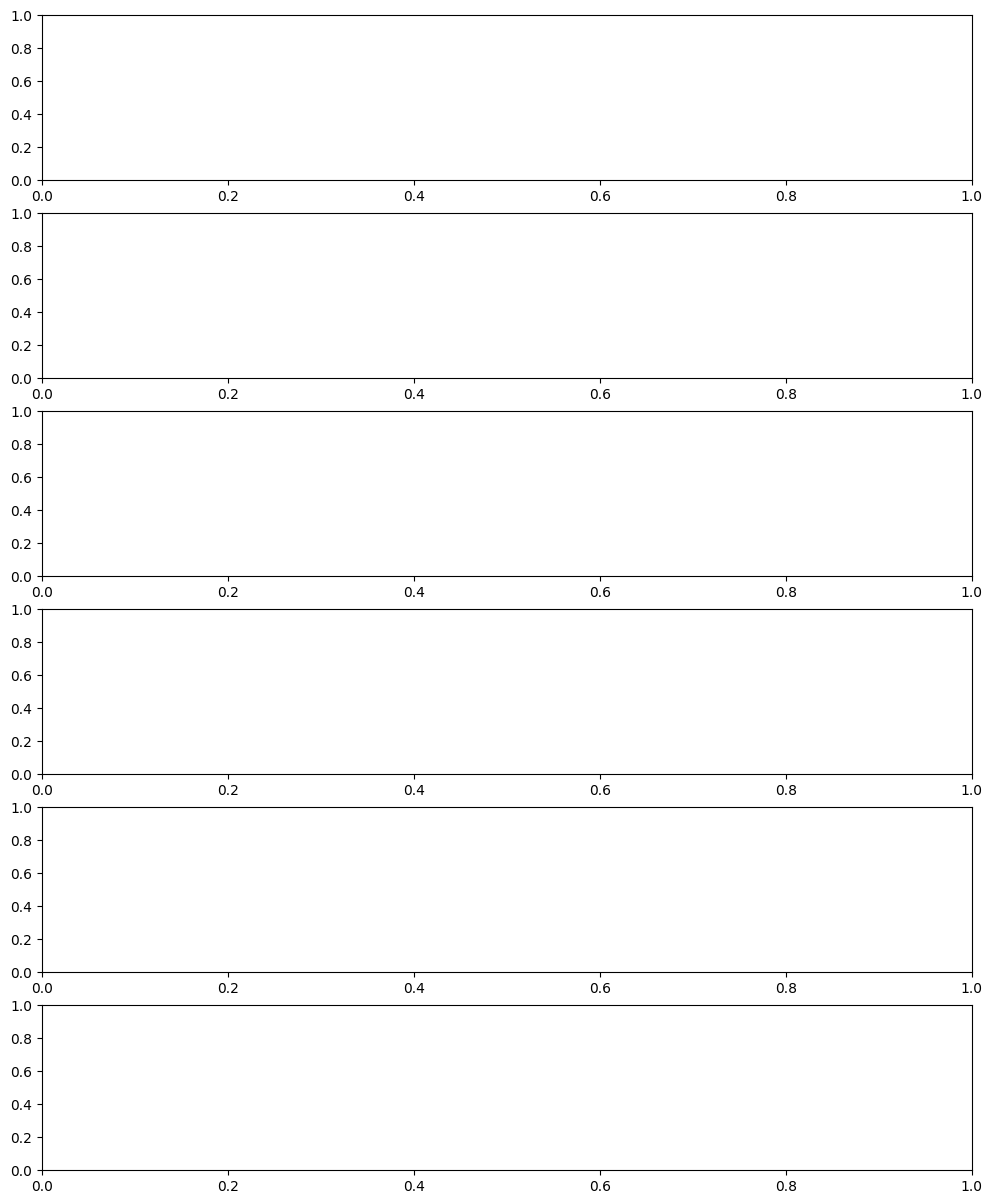

In [15]:
# Filter cleaned and not cleaned datasets
cleaned_benin = data[data['Cleaning'] == 1]
not_cleaned_benin = data[data["Cleaning"] == 0]

cleaned_togo = data3[data3['Cleaning'] == 1]
not_cleaned_togo = data3[data3["Cleaning"] == 0]

cleaned_sierra = data2[data2['Cleaning'] == 1]
not_cleaned_sierra = data2[data2["Cleaning"] == 0]

# Create subplots for the data
fig, ax = plt.subplots(6, 1, figsize=(12, 15))

# Benin: Before cleaning
ax[0].plot(not_cleaned_benin['datetime'], not_cleaned_benin['ModA'], label='ModA Not Cleaned')
ax[0].plot(not_cleaned_benin['datetime'], not_cleaned_benin['ModB'], label='ModB Not Cleaned')
ax[0].set_title('Benin Sensor Readings Before Cleaning')

# Benin: After cleaning
ax[1].plot(cleaned_benin['datetime'], cleaned_benin['ModA'], label='ModA Cleaned')
ax[1].plot(cleaned_benin['datetime'], cleaned_benin['ModB'], label='ModB Cleaned')
ax[1].set_title('Benin Sensor Readings After Cleaning')

# Sierra Leone: Before cleaning
ax[2].plot(not_cleaned_sierra['datetime'], not_cleaned_sierra['ModA'], label='ModA Not Cleaned')
ax[2].plot(not_cleaned_sierra['datetime'], not_cleaned_sierra['ModB'], label='ModB Not Cleaned')
ax[2].set_title('Sierra Leone Sensor Readings Before Cleaning')

# Sierra Leone: After cleaning
ax[3].plot(cleaned_sierra['datetime'], cleaned_sierra['ModA'], label='ModA Cleaned')
ax[3].plot(cleaned_sierra['datetime'], cleaned_sierra['ModB'], label='ModB Cleaned')
ax[3].set_title('Sierra Leone Sensor Readings After Cleaning')

# Togo: Before cleaning
ax[4].plot(not_cleaned_togo['datetime'], not_cleaned_togo['ModA'], label='ModA Not Cleaned')
ax[4].plot(not_cleaned_togo['datetime'], not_cleaned_togo['ModB'], label='ModB Not Cleaned')
ax[4].set_title('Togo Sensor Readings Before Cleaning')

# Togo: After cleaning
ax[5].plot(cleaned_togo['datetime'], cleaned_togo['ModA'], label='ModA Cleaned')
ax[5].plot(cleaned_togo['datetime'], cleaned_togo['ModB'], label='ModB Cleaned')
ax[5].set_title('Togo Sensor Readings After Cleaning')

# Add legends
plt.legend()
plt.tight_layout()
plt.show()
